# 📘 Assignment: Binary Classification with Neural Networks (circles dataset)


# Objective

Using the provided dataset circles_binary_classification.csv, reproduce and extend the workflow. Build, train, evaluate and compare PyTorch ANNs to classify the circular data and report findings.

# Dataset
circles_binary_classification.csv (place in notebook folder)


# Tasks (follow the notebook structure)
1.Data retrieval & inspection
    
    Load CSV with pandas; show head() and describe().


In [34]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn

torch.manual_seed(42)


In [39]:
df= pd.read_csv("circles_binary_classification.csv")
df.head()


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [40]:
df.describe()


,X1,X2,label
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


2.Data cleaning & feature design

    Confirm/perform minimal cleaning.
    Create X = [['X1','X2']] and y = label.
    Convert to NumPy / torch tensors with correct dtypes.

In [41]:
X = df[['X1', 'X2']].values
y = df['label'].values


In [42]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (n,1)


3.Visualize data

    Scatter plot X1 vs X2 colored by label.

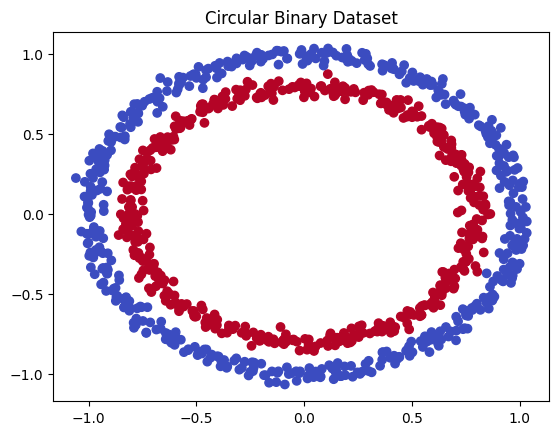

In [43]:
plt.scatter(df.X1, df.X2, c=df.label, cmap="coolwarm")
plt.title("Circular Binary Dataset")
plt.show()


4.Train/test split

    train_test_split(test_size=0.2, random_state=42).


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


5.Device & dtype

    Make code device-agnostic (cuda if available) and move tensors to device.


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


6.Implement baseline models

    ModelV0: 2 → 5 → 1 (no activation)
    ModelV1: 2 → 15 → 15 → 1 (no activation)
    ModelV2: 2 → 64 → 64 → 10 -> 1 with ReLU between layers


In [46]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2,5),
            nn.Linear(5,1)
        )
    def forward(self,x):
        return self.layer(x)


In [47]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2,15),
            nn.Linear(15,15),
            nn.Linear(15,1)
        )
    def forward(self,x):
        return self.layer(x)


In [48]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self,x):
        return self.layer(x)


7.Loss, optimizer, metrics

    Use nn.BCEWithLogitsLoss() (raw logits).
    Optimizer: torch.optim.SGD(params=model.parameters(), lr=0.1) initially.
    Accuracy: round(sigmoid(logits)).


In [49]:
loss_fn = nn.BCEWithLogitsLoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred))*100


8.Training loop

    Use same train_and_test_loop pattern: training & eval each epoch, collect losses/accuracies, print progress every 10 epochs.
    Suggested epochs: V0 ~100, V1 ~1000, V2 ~100–1500, V3 try 500–1000 (adjust as needed).
    Reinitialize model & optimizer between experiments.


In [57]:
def train_and_test(model, epochs):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)

        y_pred = torch.round(torch.sigmoid(logits))
        acc = accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss {loss:.4f} | Test Loss {test_loss:.4f}")

    return train_losses, test_losses


In [58]:
model2 = ModelV2()
train_losses, test_losses = train_and_test(model2, 500)


Epoch 0 | Train Loss 0.6957 | Test Loss 0.6943
Epoch 10 | Train Loss 0.6944 | Test Loss 0.6932
Epoch 20 | Train Loss 0.6934 | Test Loss 0.6924
Epoch 30 | Train Loss 0.6926 | Test Loss 0.6918
Epoch 40 | Train Loss 0.6918 | Test Loss 0.6913
Epoch 50 | Train Loss 0.6913 | Test Loss 0.6910
Epoch 60 | Train Loss 0.6909 | Test Loss 0.6908
Epoch 70 | Train Loss 0.6905 | Test Loss 0.6905
Epoch 80 | Train Loss 0.6900 | Test Loss 0.6902
Epoch 90 | Train Loss 0.6896 | Test Loss 0.6900
Epoch 100 | Train Loss 0.6891 | Test Loss 0.6897
Epoch 110 | Train Loss 0.6886 | Test Loss 0.6894
Epoch 120 | Train Loss 0.6881 | Test Loss 0.6891
Epoch 130 | Train Loss 0.6876 | Test Loss 0.6887
Epoch 140 | Train Loss 0.6870 | Test Loss 0.6884
Epoch 150 | Train Loss 0.6863 | Test Loss 0.6880
Epoch 160 | Train Loss 0.6856 | Test Loss 0.6875
Epoch 170 | Train Loss 0.6848 | Test Loss 0.6871
Epoch 180 | Train Loss 0.6840 | Test Loss 0.6865
Epoch 190 | Train Loss 0.6830 | Test Loss 0.6859
Epoch 200 | Train Loss 0.6819 |

9.Predictions & evaluation

    Show untrained and trained predictions.
    Plot decision boundaries for train & test (use/adapt plot_decision_boundary).
    Plot train & test loss curves.


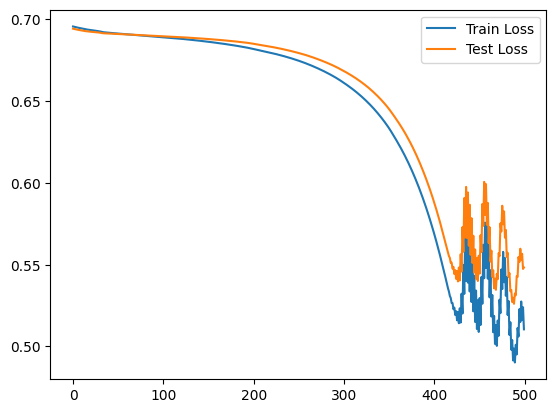

In [59]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()


10.Discussion and Conclusion

    

In this experiment, different neural network models were trained on a circular dataset that is not linearly separable.
Model V0 and Model V1 did not use activation functions, so they behaved like linear models and failed to learn the circular boundary, giving accuracy close to random guessing (~50%). Increasing layers without non-linearity did not help.

Model V2 used ReLU activation, which introduced non-linearity. This allowed the network to learn a curved decision boundary, leading to a strong drop in loss and very high accuracy (around 95–100%). Training and test losses decreased together, showing good generalization.

Conclusion

This assignment proves that:

Linear models cannot solve non-linear problems like circular data.

Activation functions (ReLU) are essential for neural networks to learn complex patterns.

Model depth alone is not enough — non-linearity makes the difference.

The device-agnostic setup ensures the model runs efficiently on both CPU and GPU.

Model V2 performed best and successfully solved the classification task.